Name: Zixi Wang

Github Username: lacunaxu

USC ID: 2854187591

1. 
Decision Trees as Interpretable Models

(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

(b) Build a decision tree on the whole data set and plot it.

(c) Convert the decision rules into a set of IF-THEN rules.

(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [1]:
import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
#1(a)
#I used open file to confirm that the file type was a UTF-16 encoded file, 
# and then I used chatgpt to help me read the UTF-16 encoded file using csv

overall_path = os.getcwd()
new_path = os.path.dirname(overall_path)
path = os.path.join(new_path, 'data', 'Accute_Inflamations', 'diagnosis.data')
print("文件路径:", path)

try:
    data = pd.read_csv(path, header=None, encoding='utf-16', delimiter='\t', decimal=',')

    data.columns = [
        "Temperature", "Nausea", "Lumbar_pain", "Urine_pushing", 
        "Micturition_pains", "Burning_itch_swelling", "Bladder_inflammation", "Nephritis"
    ]
    
    print(data.head())
except Exception as e:
    print("Error loading file:", e)

文件路径: C:\Users\wumin\homework-5-lacunaxu\data\Accute_Inflamations\diagnosis.data
   Temperature Nausea Lumbar_pain Urine_pushing Micturition_pains  \
0         35.5     no         yes            no                no   
1         35.9     no          no           yes               yes   
2         35.9     no         yes            no                no   
3         36.0     no          no           yes               yes   
4         36.0     no         yes            no                no   

  Burning_itch_swelling Bladder_inflammation Nephritis  
0                    no                   no        no  
1                   yes                  yes        no  
2                    no                   no        no  
3                   yes                  yes        no  
4                    no                   no        no  


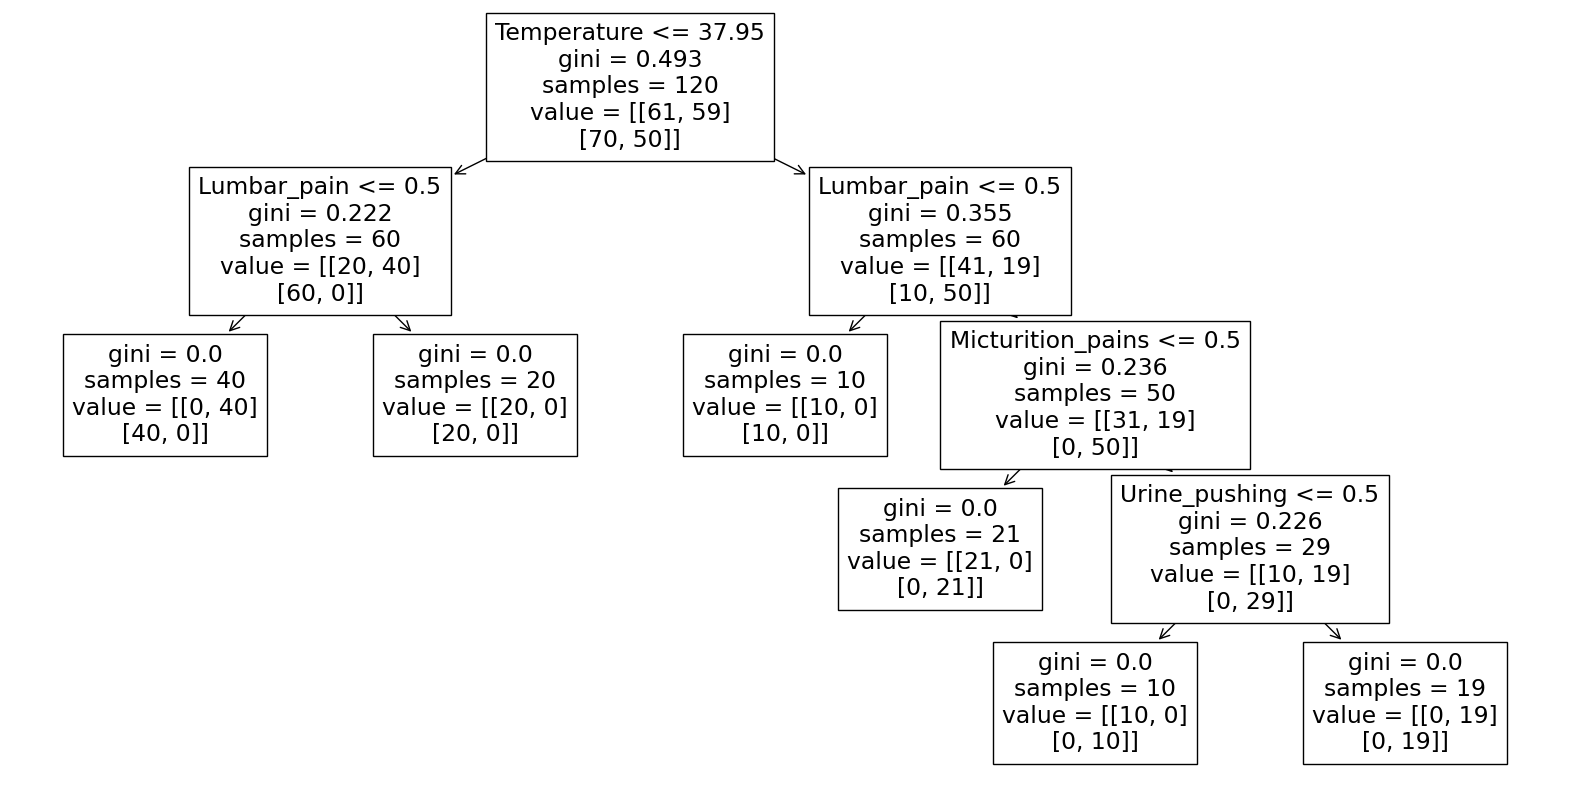

In [3]:
#1(b)
X = data[["Temperature", "Nausea", "Lumbar_pain", "Urine_pushing", 
              "Micturition_pains", "Burning_itch_swelling"]]
    
y= data[["Bladder_inflammation", "Nephritis"]]

X_whole = X.replace({'yes': 1, 'no': 0})
y_whole = y.replace({'yes': 1, 'no': 0})

model = DecisionTreeClassifier()
model.fit(X_whole, y_whole)

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns)
plt.show()

In [4]:
#1(c)
rules = tree.export_text(model, feature_names=list(X.columns))
print(rules)

|--- Temperature <= 37.95
|   |--- Lumbar_pain <= 0.50
|   |   |--- class: 1
|   |--- Lumbar_pain >  0.50
|   |   |--- class: 0
|--- Temperature >  37.95
|   |--- Lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- Lumbar_pain >  0.50
|   |   |--- Micturition_pains <= 0.50
|   |   |   |--- class: 0
|   |   |--- Micturition_pains >  0.50
|   |   |   |--- Urine_pushing <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Urine_pushing >  0.50
|   |   |   |   |--- class: 0



Number of nodes is: 11 and the ccp_alpha is: 0.1899053335285219
Number of nodes is: 7 and the ccp_alpha is: 0.1899053335285219
Number of nodes is: 5 and the ccp_alpha is: 0.1899053335285219
Number of nodes is: 3 and the ccp_alpha is: 0.1899053335285219
Number of nodes is: 1 and the ccp_alpha is: 0.1899053335285219


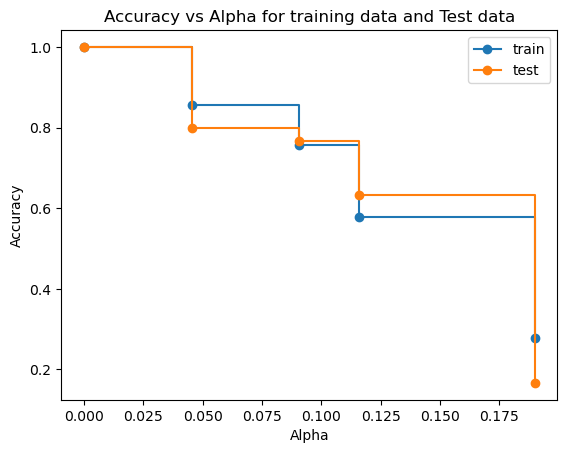

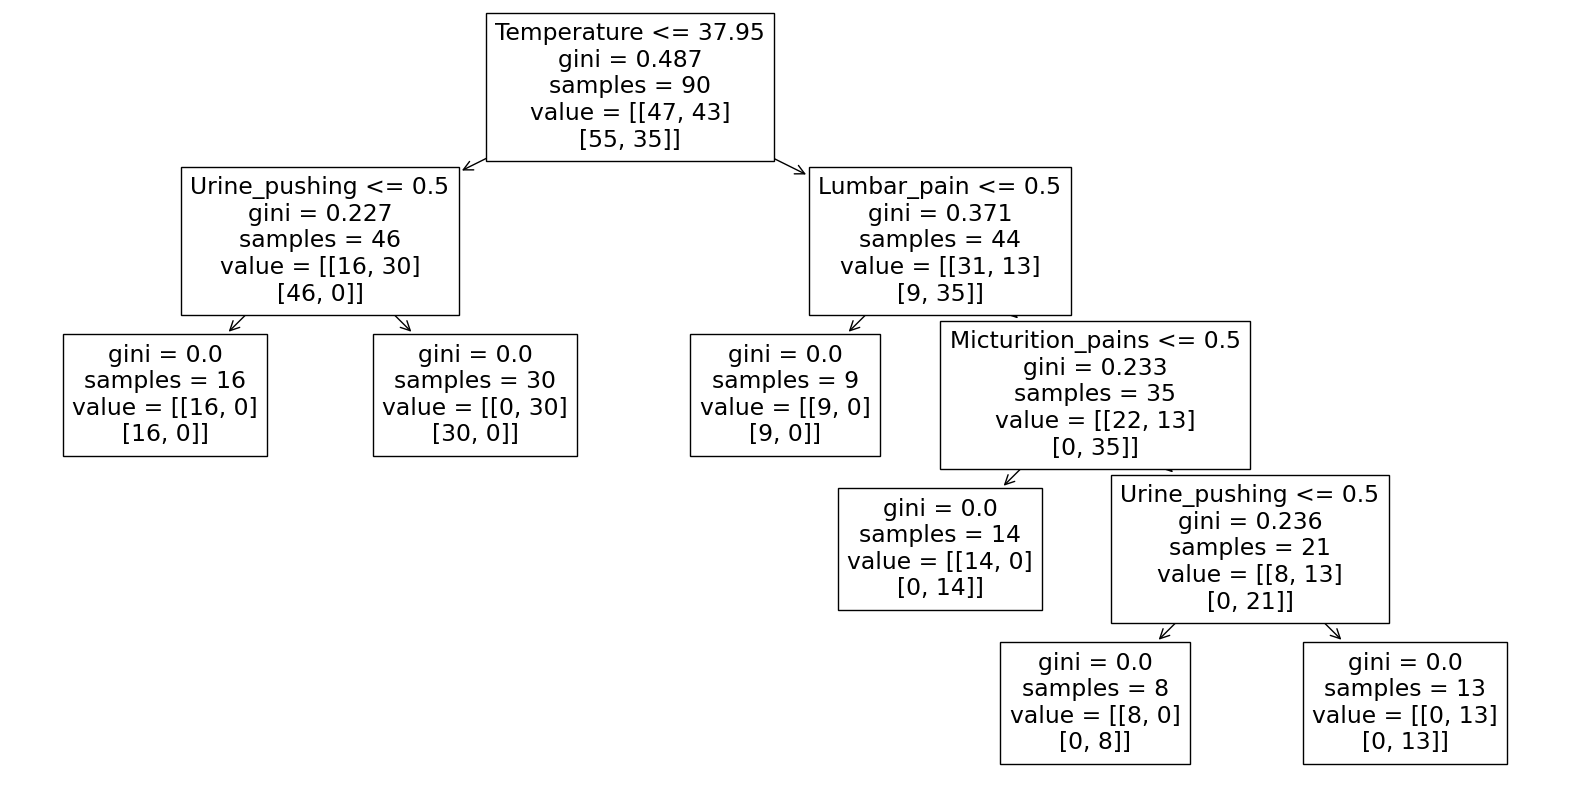

|--- Temperature <= 37.95
|   |--- Urine_pushing <= 0.50
|   |   |--- class: 0
|   |--- Urine_pushing >  0.50
|   |   |--- class: 1
|--- Temperature >  37.95
|   |--- Lumbar_pain <= 0.50
|   |   |--- class: 0
|   |--- Lumbar_pain >  0.50
|   |   |--- Micturition_pains <= 0.50
|   |   |   |--- class: 0
|   |   |--- Micturition_pains >  0.50
|   |   |   |--- Urine_pushing <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Urine_pushing >  0.50
|   |   |   |   |--- class: 0



In [5]:
#1(d)
X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, random_state=14)

# I searched online to find the way for doing these
clf = DecisionTreeClassifier(random_state=14)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=14, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    print(
    "Number of nodes is: {} and the ccp_alpha is: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha for training data and Test data")
ax.legend()
plt.show()

best_alpha = ccp_alphas[test_scores.index(max(test_scores))]
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# 绘制剪枝后的树结构
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns)
plt.show()

rules = export_text(pruned_tree, feature_names=list(X.columns))
print(rules)

2. The LASSO and Boosting for Regression

(a) Download the Communities and Crime data from UCI Communities and Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

(c) Plot a correlation matrix for the features in the data set.

(d) Calculate the Coefficient of Variation (CV) for each feature, where CV = s/m, in which 𝑠 is the sample standard deviation and m is the sample mean.

(e) Pick sqrt(128) features with the highest CV, and make scatter plots and box plots for them. Can you draw conclusions about the significance of those features just by the scatter plots?

(f) Fit a linear model using least squares to the training set and report the test error.

(g) Fit a ridge regression model on the training set, with 
𝜆
λ chosen by cross-validation. Report the test error obtained.

(h) Fit a LASSO model on the training set, with 𝜆 chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

(j) Fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, use L1-penalized regression at each node. Such a tree is called an 
L1-penalized gradient boosting tree. Use XGBoost to fit the model tree and determine 𝛼 (the regularization term) using cross-validation.

In [6]:
#2(a)
communities_file_path = os.path.join(new_path, 'data', 'Accute_Inflamations',
                                     'communities.data')
communities_file_name_path = os.path.join(new_path, 
                                          'data', 
                                          'Accute_Inflamations', 
                                          'communities.names')

column_names = []
with open(communities_file_name_path, 'r') as file:
    for line in file:
        if line.startswith("@attribute"):
            column_name = line.split()[1]
            column_names.append(column_name)
            
communities_data = pd.read_csv(communities_file_path, header=None, 
                               names=column_names, na_values="?")

non_predictive_columns = ["state", "county", "community", "communityname", "fold"]
communities_data = communities_data.drop(non_predictive_columns, axis=1)

training_data = communities_data.iloc[:1495, :]
test_data = communities_data.iloc[1495:, :]

training_data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [7]:
#2(b)
imputed_training_data = training_data.fillna(training_data.mean())
imputed_test_data = test_data.fillna(test_data.mean())

imputed_training_data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [8]:
#2(c)
corr_training_matrix = imputed_training_data.corr()
corr_training_matrix

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.000000,-0.040404,0.242144,-0.306023,0.168868,0.162282,0.014554,0.128721,0.075744,-0.107060,...,0.747424,0.235510,0.283682,0.630778,0.591778,-0.063029,0.041216,0.464459,-0.011305,0.364245
householdsize,-0.040404,1.000000,-0.068374,-0.243565,0.209848,0.473320,0.517742,0.371658,0.301949,-0.606714,...,-0.020832,-0.003807,-0.030652,-0.014900,0.004813,-0.024445,0.008771,-0.086315,-0.021276,-0.031156
racepctblack,0.242144,-0.068374,1.000000,-0.793431,-0.104912,-0.069449,0.118272,0.143406,0.125330,0.056381,...,0.155017,0.101270,0.169002,0.142543,0.104193,-0.113466,0.022226,0.257781,0.042346,0.644094
racePctWhite,-0.306023,-0.243565,-0.793431,1.000000,-0.270829,-0.436737,-0.189135,-0.258390,-0.175195,0.138619,...,-0.147054,-0.339787,-0.234460,-0.131432,-0.126551,0.077626,-0.048890,-0.272366,-0.029339,-0.690614
racePctAsian,0.168868,0.209848,-0.104912,-0.270829,1.000000,0.264600,-0.017945,0.106958,0.056442,-0.283709,...,0.004790,0.360708,0.274826,-0.023657,0.044584,0.031598,0.050863,0.100653,-0.004045,0.034705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.063029,-0.024445,-0.113466,0.077626,0.031598,0.018398,-0.025210,-0.008902,-0.006311,0.021422,...,-0.067853,0.068739,0.028476,-0.118489,-0.070216,1.000000,-0.033617,0.032430,-0.187790,-0.048109
LemasGangUnitDeploy,0.041216,0.008771,0.022226,-0.048890,0.050863,0.048441,0.035629,0.016274,0.015603,-0.034216,...,0.070956,-0.071059,-0.084771,0.008831,-0.013583,-0.033617,1.000000,-0.017356,-0.040769,0.075703
LemasPctOfficDrugUn,0.464459,-0.086315,0.257781,-0.272366,0.100653,0.126210,0.012529,0.117998,0.083582,-0.022575,...,0.322885,0.236545,0.209710,-0.058210,-0.068059,0.032430,-0.017356,1.000000,0.017402,0.331882
PolicBudgPerPop,-0.011305,-0.021276,0.042346,-0.029339,-0.004045,0.025112,-0.050001,-0.038149,-0.033481,0.042617,...,-0.105834,0.095796,0.105645,0.275048,0.297196,-0.187790,-0.040769,0.017402,1.000000,0.078912


In [9]:
#2(d)
imputed_training_data_without_ViolentCrimesPerPop = imputed_training_data.drop(columns=["ViolentCrimesPerPop"])
cv_training = imputed_training_data_without_ViolentCrimesPerPop.mean() / imputed_training_data_without_ViolentCrimesPerPop.std()

cv_training_df = pd.DataFrame(cv_training, columns=['Coefficient of Variation'])
print(cv_training_df)

                     Coefficient of Variation
population                           0.446209
householdsize                        2.810571
racepctblack                         0.699846
racePctWhite                         3.028351
racePctAsian                         0.735781
...                                       ...
PolicOperBudg                        1.345014
LemasPctPolicOnPatr                  8.640139
LemasGangUnitDeploy                  2.754902
LemasPctOfficDrugUn                  0.391704
PolicBudgPerPop                      3.067244

[122 rows x 1 columns]


In [10]:
features = int(np.sqrt(128))
top_training_features = cv_training.nlargest(features).index
top_training_data = imputed_training_data[top_training_features]
print(top_training_data.head())
top_test_data = imputed_test_data[top_training_features]

   LemasSwFTFieldOps  LemasPctPolicOnPatr  PctPolicWhite  RacialMatchCommPol  \
0           0.960000             0.900000       0.930000            0.940000   
1           0.919205             0.713054       0.725314            0.682301   
2           0.919205             0.713054       0.725314            0.682301   
3           0.919205             0.713054       0.725314            0.682301   
4           0.919205             0.713054       0.725314            0.682301   

   NumKindsDrugsSeiz  PolicReqPerOffic  LemasSwFTFieldPerPop  PctHousOccup  \
0            0.57000          0.440000              0.170000          0.71   
1            0.55205          0.344561              0.245272          0.79   
2            0.55205          0.344561              0.245272          0.86   
3            0.55205          0.344561              0.245272          0.97   
4            0.55205          0.344561              0.245272          0.89   

   PctSpeakEnglOnly  agePct12t29  LemasSwFTPerPop 

C:\Users\wumin\AppData\Local\Temp\ipykernel_8236\70238809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_top_training_data['ViolentCrimesPerPop'] = imputed_training_data['ViolentCrimesPerPop']


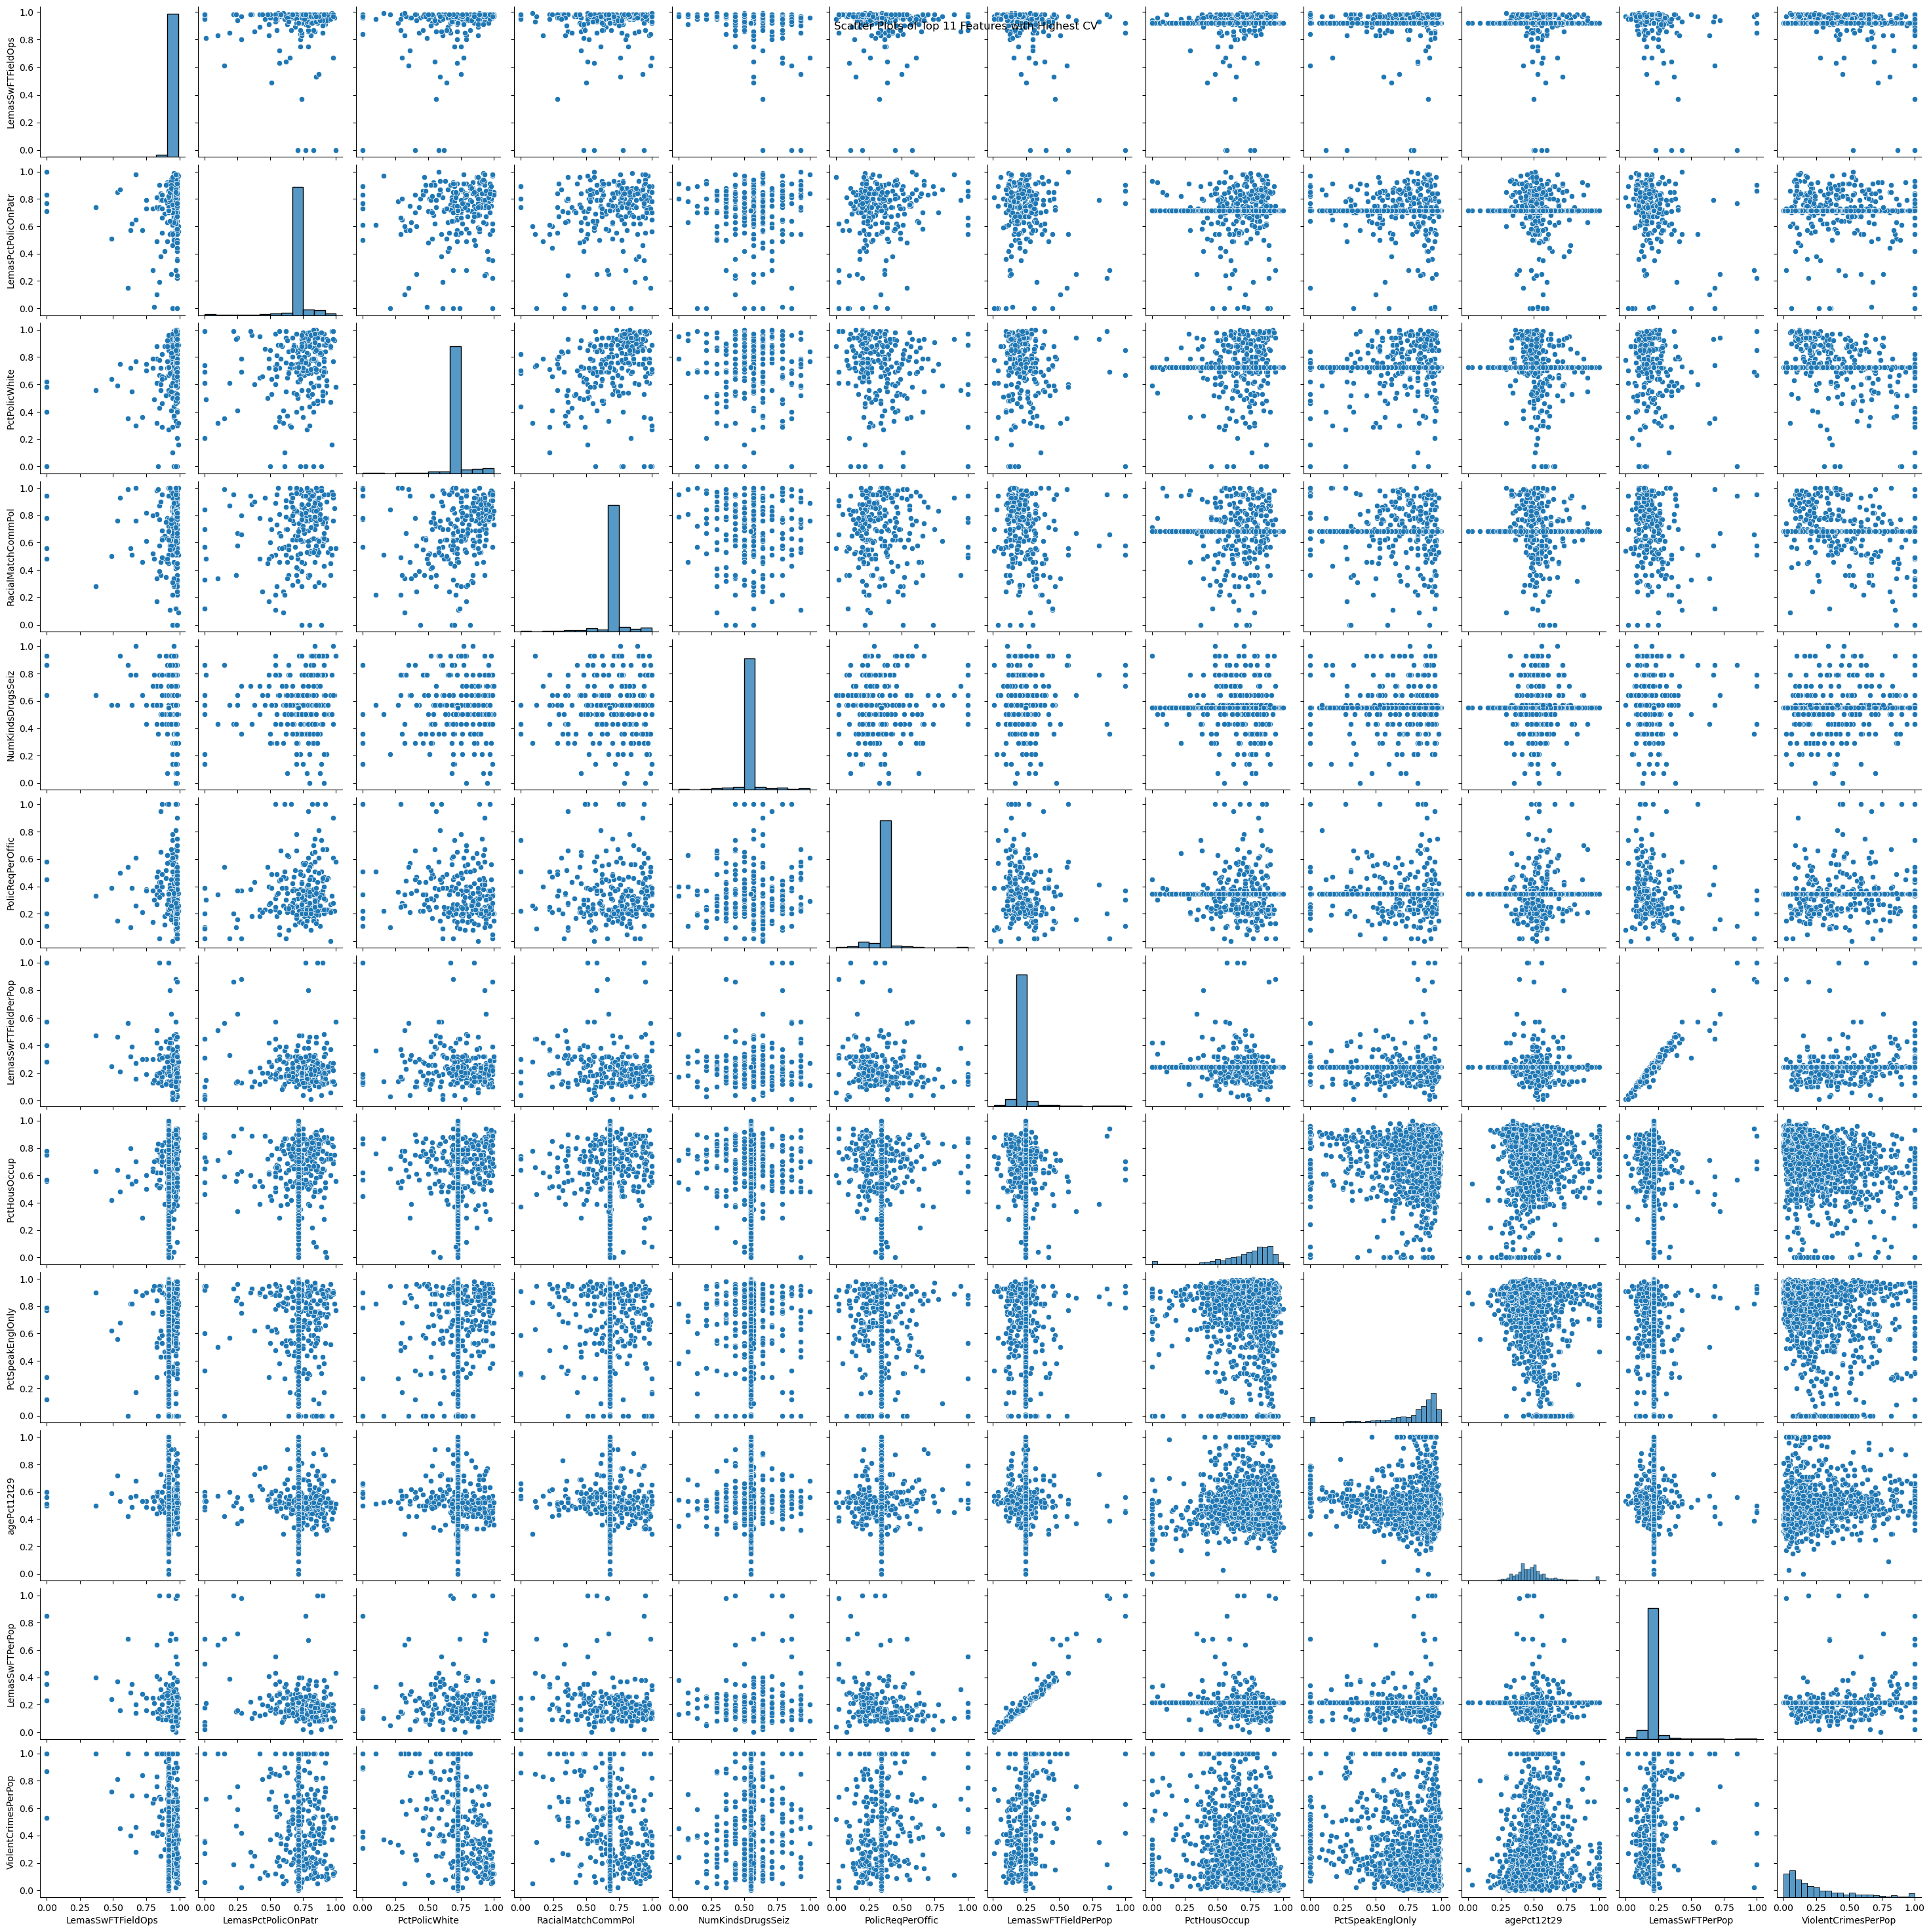

<Figure size 1500x1000 with 0 Axes>

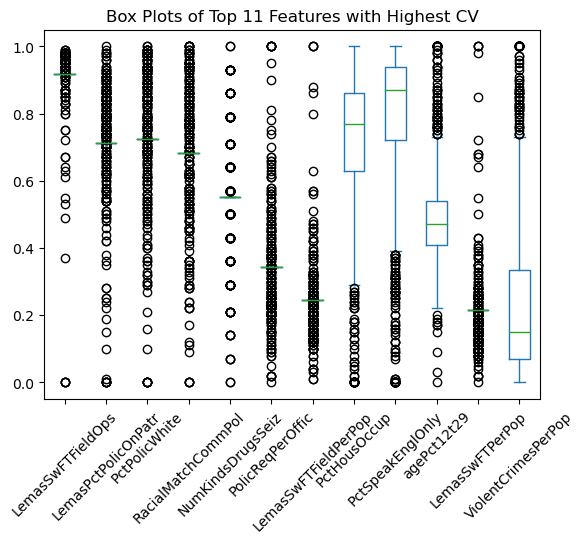

In [11]:
temp_top_training_data = top_training_data
temp_top_training_data['ViolentCrimesPerPop'] = imputed_training_data['ViolentCrimesPerPop']

sns.pairplot(temp_top_training_data)
plt.suptitle("Scatter Plots of Top 11 Features with Highest CV")
plt.show()

plt.figure(figsize=(15, 10))
temp_top_training_data.plot(kind='box')
plt.title("Box Plots of Top 11 Features with Highest CV")
plt.xticks(rotation=45)
plt.show()

From the scatter plot, there is no obvious linear trend between some features and ViolentCrimesPerPop. The relationship between features is also scattered, indicating that the correlation between these variables may be weak. LemasSwFTFieldOps and PctPolicWhite show a nonlinear relationship or distribution pattern.
The box plot shows the distribution of each feature, and some features (such as NumKindsDrugsSeiz and PolicReqPerOffic) show large variability. Many features have a large number of outliers (such as LemasSwFTFieldOps and PolicPerPop), which indicates that these features vary significantly between different communities.

In [12]:
#2(f)
X_train = top_training_data.drop(columns=["ViolentCrimesPerPop"], errors='ignore')
y_train = imputed_training_data["ViolentCrimesPerPop"]
X_test = top_test_data.drop(columns=["ViolentCrimesPerPop"], errors='ignore')
y_test = imputed_test_data["ViolentCrimesPerPop"]

linear_model = LinearRegression().fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

linear_test_error = mean_squared_error(y_test, y_pred_linear)
print("Linear regression model test error is:", linear_test_error)

Linear regression model test error is: 0.03644906919952131


In [15]:
#2(g)
r_alphas= np.logspace(-10, 10, 100)

ridge_regression_model = RidgeCV(alphas=r_alphas, scoring='r2').fit(X_train, y_train)

y_pred_ridge = ridge_regression_model.predict(X_test)
ridge_test_error = mean_squared_error(y_test, y_pred_ridge)

print("Best ridge_regression_model lambda is :", ridge_regression_model.alpha_)
print("ridge regression model test error is:", ridge_test_error)

Best ridge_regression_model lambda is : 1.2618568830660184
ridge regression model test error is: 0.03636969128383727


In [16]:
#2(h)

LASSO_model = LassoCV(alphas=r_alphas, cv=5, random_state=14).fit(X_train, y_train)

y_pred_lasso = LASSO_model.predict(X_test)
LASSO_test_error = mean_squared_error(y_test, y_pred_lasso)

# 打印最佳 alpha 和测试误差
print("Best LASSO_model lambda is :", LASSO_model.alpha_)
print("LASSO Model model test error is:", LASSO_test_error)
variables=LASSO_model.coef_
selected_indices =  list(X_train.columns[np.where(variables != 0)[0]])
print("The variables selected by LASSO Model is:", selected_indices)

Best LASSO_model lambda is : 0.00011497569953977356
LASSO Model model test error is: 0.03639708469343066
The variables selected by LASSO Model is: ['LemasSwFTFieldOps', 'LemasPctPolicOnPatr', 'PctPolicWhite', 'RacialMatchCommPol', 'NumKindsDrugsSeiz', 'PolicReqPerOffic', 'PctHousOccup', 'PctSpeakEnglOnly', 'agePct12t29', 'LemasSwFTPerPop']


In [17]:
#2(h)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LASSO_model_scaled = LassoCV(alphas=r_alphas, cv=5, random_state=14).fit(X_train_scaled, y_train)

y_pred_lasso_scaled = LASSO_model_scaled.predict(X_test_scaled)

LASSO_scaled_test_error = mean_squared_error(y_test, y_pred_lasso_scaled)

print("Best scaled LASSO_model lambda is :", LASSO_model_scaled.alpha_)
print("LASSO scaled Model test error is:", LASSO_scaled_test_error)

variables_scaled = LASSO_model_scaled.coef_
selected_variables_scaled = list(X_train.columns[np.where(variables_scaled != 0)[0]])
print("The variables selected by LASSO scaled Model are:", selected_variables_scaled)


Best scaled LASSO_model lambda is : 0.0011768119524349992
LASSO scaled Model test error is: 0.03639765584384425
The variables selected by LASSO scaled Model are: ['LemasSwFTFieldOps', 'LemasPctPolicOnPatr', 'PctPolicWhite', 'RacialMatchCommPol', 'NumKindsDrugsSeiz', 'PolicReqPerOffic', 'PctHousOccup', 'PctSpeakEnglOnly', 'agePct12t29', 'LemasSwFTPerPop']


In [24]:
#(i)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1])
mse_list = []

for m in range(1, max_components + 1):
    pca = PCA(n_components=m)
    X_PCA = pca.fit_transform(X_train_scaled)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=14)
    MSE = []

    for train_index, val_index in kf.split(X_PCA):
        x_train, x_val = X_PCA[train_index], X_PCA[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

        model = LinearRegression().fit(x_train, y_train_cv)
        pred = model.predict(x_val)
        MSE.append(mean_squared_error(y_val_cv, pred))

    mse_list.append(np.mean(MSE))

best_m = np.argmin(mse_list) + 1
print("Best M:", best_m)

pca = PCA(n_components=best_m)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred_pcr = model.predict(X_test_pca)
pcr_test_error = mean_squared_error(y_test, y_pred_pcr)

print("PCR Model Test Error is:", pcr_test_error)

Best M: 10
PCR Model Test Error is: 0.03636851306084513


In [25]:
#2(j)
lambdas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 10]
xgb_model = XGBRegressor(random_state=14)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid={'reg_alpha': lambdas},
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

mse_scores = -grid_search.cv_results_['mean_test_score']  # 转换为正的均方误差
best_index = np.argmin(mse_scores)
best_alpha = lambdas[best_index]  # 获取对应的 alpha
best_score = mse_scores[best_index] 

print("Best alpha is:", best_alpha)
print("Cross-validated MSE is:", best_score)

XGBoost_model = XGBRegressor(reg_alpha=best_alpha).fit(X_train, y_train)

y_pred = XGBoost_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print("Test MSE:", test_mse)

Best alpha is: 2
Cross-validated MSE is: 0.03504046955668764
Test MSE: 0.029500502094022656
